## Social vulnerability and Covid-19 in Chile

1. Covid-19 in Chile
    1. Covid-19 in Chile and worldwide
    2. Timeline of Covid-19 cases and deaths in Chile 
    3. Which are the 10 most affected districts in Chile (cases) at four different times during the pandemic
    4. Which are the 10 most affected districts in Chile (deaths) at four different times during the pandemic
    
2. The CASEN data

In [78]:
# Read in libraries
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

# Read in CASEN data about social vulnerability
casen = pd.read_stata('Casen 2017.dta', convert_categoricals = False)

# Read in data about Covid-19 in Chilen regions
cases_regions = pd.read_csv(
    'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto3/CasosTotalesCumulativo_T.csv',
    parse_dates = True
)



deaths_regions = pd.read_csv(
    'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto14/FallecidosCumulativo_T.csv',
    parse_dates = True
)

# Read in data about Covid-19 in Chilean districts
cases_districts = pd.read_csv(
    'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto1/Covid-19.csv'
)

cases_districts = cases_districts[~cases_districts.Comuna.str.contains('Desconocido')]


deaths_districts = pd.read_csv(
    'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto38/CasosFallecidosPorComuna.csv'
)

deaths_districts = deaths_districs[~deaths_districs.Comuna.str.contains('Desconocido')]
deaths_districts = deaths_districs[~deaths_districs.Comuna.str.contains('Total')]



# Read in data about Covid-19 worldwide
csse_cases_all = pd.read_csv(
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
csse_deaths_all = pd.read_csv(
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

In [2]:
# Select only 49 relevant indicators from the CASEN study, such as poverty, access to health institutions or
# number of persons in household. 

casen_columns = ['region', 'provincia', 'comuna', 'e1', 'e6a', 'o1', 'o12', 'o16', 'o25a_min',
                'o25c', 'o28', 'y21a', 'y22a', 'y24', 'y27a', 'ysub', 'ytot', 's12', 's13', 's14', 
                's26a', 's27a', 's28', 's31a1', 's31a2', 's31a3', 's32c', 's33g1', 's33i1', 's33j1',
                'r1a', 'r1a_cod', 'r3', 'r7c', 'r8a', 'r8b', 'r16a', 'r16b', 'v33', 'v37a', 'v37c',
                'v37i', 'v39b', 'pobreza', 'hh_d_prevs', 'hh_d_cot', 'hh_d_servbas', 'qaut', 'numper']

# print(len(casen_columns))

casen_rel = casen[casen_columns]
# cases.iloc[:, [1, -2]]

In [30]:
def timeline_plot(df, title):
    """
    A function to plot a seaborn diagram which shows the development of Covid-19 data in Chile. 
    For better readability, the function returns a log scale plot. 
    
    Input: 
        df (DataFrame): A transposed DataFrame where the first row (not the index) is the date and the columns are the 
        regions. 
        title (string): Specify the kind of the plot (cases or deaths) 
        
    Output: 
        A seaborn plot. 
    """

    # Transform wide dataframe to long dataframe 
    df_melt = pd.melt(
        df, id_vars = 'Region', 
        value_vars = df.columns.drop('Region'),
        var_name='Regions', 
        value_name='Cases'
    )

    # Apply pandas to datetime and rename column for better understanding
    df_melt['Region'] = pd.to_datetime(df_melt['Region'], format = '%Y-%m-%d')
    df_melt = df_melt.rename(columns = {'Region': 'Date'}).sort_values('Cases', ascending = False)

    # Make a plot 
    f, ax = plt.subplots(figsize = (16, 10))
    g = sns.lineplot(
        df_melt.Date, 
        df_melt.Cases, 
        hue = df_melt.Regions
    )

    plt.xlabel('Date', fontsize = 12)
    plt.ylabel('{}'.format(title), fontsize = 12)
    plt.title('Covid-19 {} in Chile (log scale)'.format(title), fontsize = 12)
    
    plt.tick_params(labelsize=12)
    ax.yaxis.tick_right()
    ax.set_yscale('log')


    plt.grid(False)
    ax.yaxis.grid()
    sns.despine()
    plt.show()
            

In [27]:
def plot_covid_worldwide(df, title, country, m):
    """
    Function to plot a comparison between the m-most affected countries (as per 100.000 habitants) 
    and a specific country, which is highlighted in red. 
    
    If the specific country is not wihtin the m-most affected countries, it is appended at the end. 
    
    Input: 
        df (DataFrame): DataFrame with country data
        title (string): Specify the kind of the plot (cases or deaths) 
        country (string): The country that sould be highlighted
        m (int): Returns the m-most affected countries. 
        
    Output: 
        A seaborn plot. 
    """
    
    # Get the relevant columns of df (Countryname and total number) and add a new column
    # of cases/deaths per 100.000 habitants. Rename the columns. 
    df_current = df.iloc[:, [1, -1]]
    df_current.columns = ['Country', title]
    df_current.loc[:, 'per 100.000'] = df_current.loc[:, title] / 100000

    # Groupby country and get the m-most affected countries. 
    df_current = df_current.groupby(
        'Country')[
        'per 100.000'].sum().reset_index().sort_values([
        'per 100.000'], ascending = False)
    
    df_current_head = df_current.head(m)

    # Check if specific country is part of the m-most affected countries
    if country in list(df_current_head.Country) == True:

        # Get index of specific country in country list
        index = list(df_current_head.Country).index(country)

        # Plot the figure
        f = plt.figure(figsize = (16, 10))
        ax = f.add_subplot(1,1,1)

        ax = sns.barplot(y = df_current_head['Country'], x = df_current_head['per 100.000'], color = 'darkgrey')
        plt.ylabel('Country', fontsize = 12)
        plt.xlabel('{} per 100.000 habitants'.format(title), fontsize = 12)
        plt.title('Covid-19 {} per 100.000 habitants worldwide'.format(title), fontsize = 12)
        ax.get_children()[index].set_color('darkred') 

        plt.tick_params(labelsize=12)

        plt.grid(False)
        ax.xaxis.grid()
        sns.despine()
        plt.show()


    # If the specific country is not within the m-most affected countries, append it to the list
    else:

        df_current_head = df_current_head.append(df_current[df_current['Country'] == country])
        index = list(df_current_head.Country).index(country)

        f = plt.figure(figsize = (16, 10))
        ax = f.add_subplot(1,1,1)

        ax = sns.barplot(y = df_current_head['Country'], x = df_current_head['per 100.000'], color = 'darkgrey')
        plt.ylabel('Country', fontsize = 12)
        plt.xlabel('{} per 100.000 habitants'.format(title), fontsize = 12)
        plt.title('Covid-19 {} per 100.000 habitants worldwide'.format(title), fontsize = 12)
        ax.get_children()[index].set_color('darkred') 

        plt.tick_params(labelsize=12)

        plt.grid(False)
        ax.xaxis.grid()
        sns.despine()
        plt.show()
    


In [68]:
def get_most_affected_districts(df, title, m):
    """
    Function to get the most affected districts.
    
    Input: 
        df (DataFrame): DataFrame with information about districts and numbers of cases/deaths
        title (string): Specify the kind of the data (cases or deaths)
        m (int): Returns the m-most affected districts.
        
    Output:
        most_affected (DataFrame): DataFrame with the m-most affected districts
    """

    # Get the relevant columns from dataframe and rename them
    df_relevant = df.iloc[:, [0, 2, -2]]
    df_relevant.columns = ['Region', 'District', title]
    
    # Group by District and drop "index" column
    most_affected = df_relevant.groupby(
        'District').agg({
        'Region': 'max', title: 'sum'}).reset_index().sort_values(
        title, ascending = False).head(10).reset_index()
    
    most_affected = most_affected.drop(['index'], axis = 1)  
    
    return most_affected


## 1. Covid-19 in Chile

###     A. Covid-19 in Chile and worldwide

First, lets have a look at the spread of Covid-19 in Chile and worldwide. Therefore, we compare the number of cases and deaths per 100.000 habitants. 

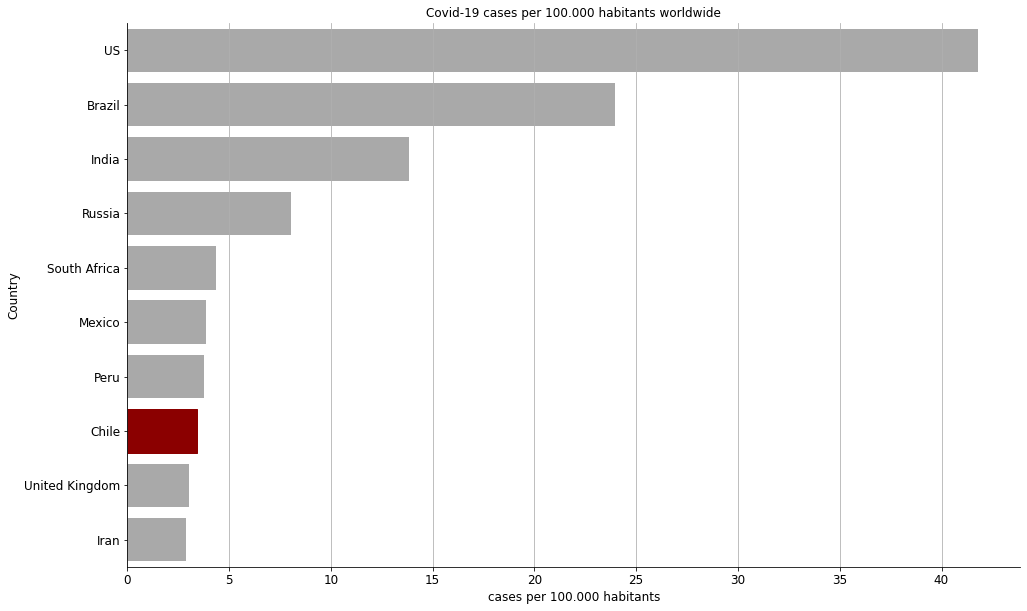

In [28]:
plot_covid_worldwide(csse_cases_all, 'cases', 'Chile', 10)

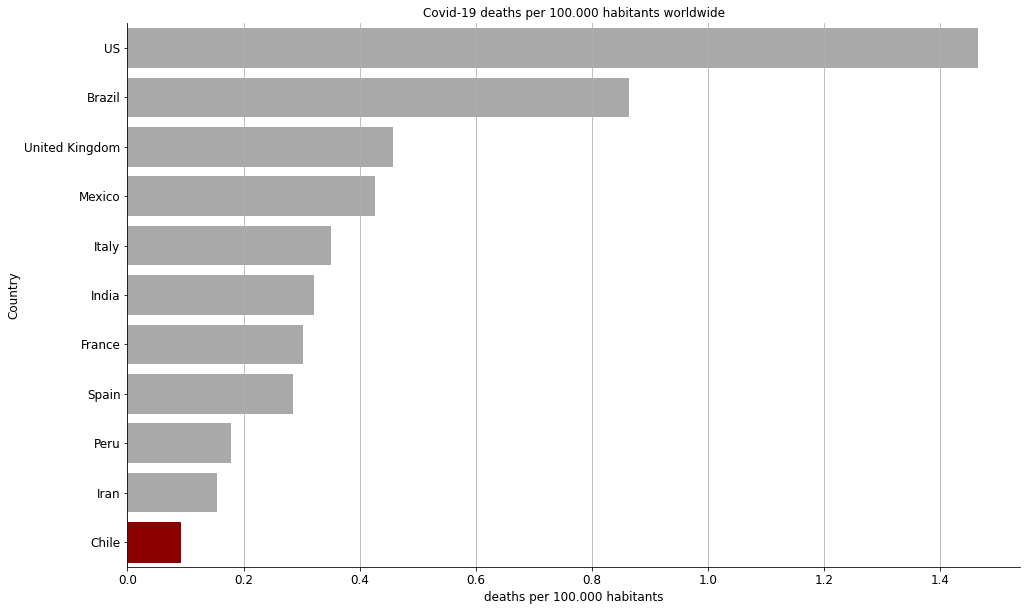

In [29]:
plot_covid_worldwide(csse_deaths_all, 'deaths', 'Chile', 10)

### B. Timeline of Covid-19 cases and deaths in Chile 

Next, we will focus on the situation in Chile. Chile is separated into 16 different regions, where "Metropolitana" is the region where the capital Santiago de Chile is located. 

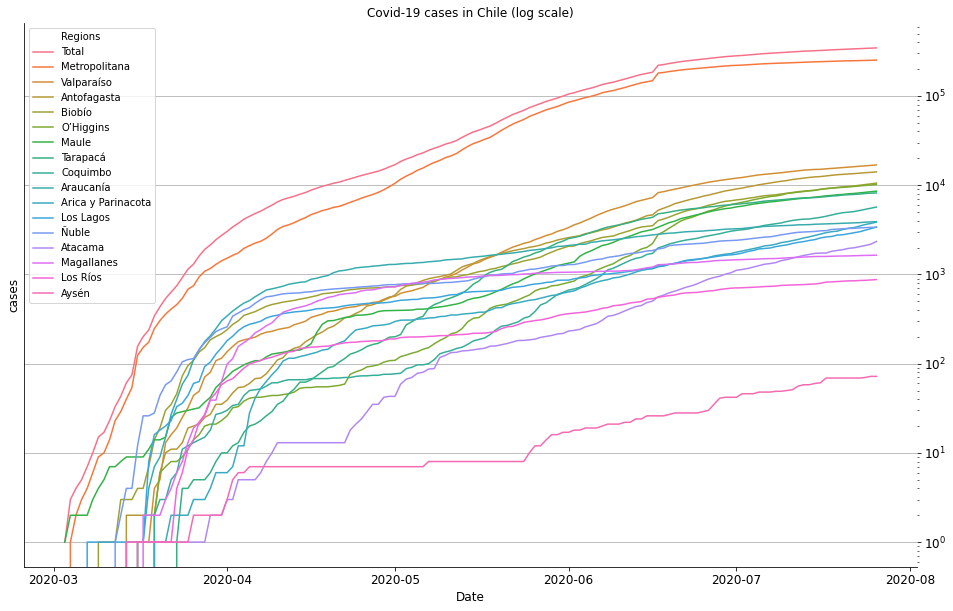

In [31]:
timeline_plot(cases_regions, 'cases')

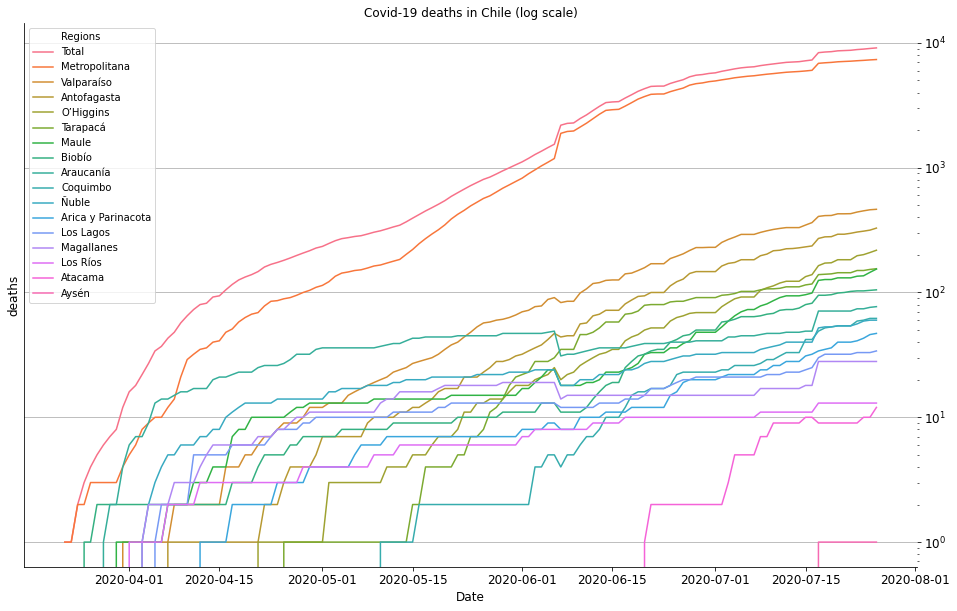

In [32]:
timeline_plot(deaths_regions, 'deaths')

In [79]:
get_most_affected_districts(cases_districts, 'cases', 10)

,District,Region,cases
0,Puente Alto,Metropolitana,21893.0
1,Santiago,Metropolitana,14329.0
2,Maipu,Metropolitana,13848.0
3,La Florida,Metropolitana,13038.0
4,Penalolen,Metropolitana,11281.0
5,San Bernardo,Metropolitana,10576.0
6,La Pintana,Metropolitana,9677.0
7,Pudahuel,Metropolitana,9368.0
8,Quilicura,Metropolitana,8672.0
9,Recoleta,Metropolitana,8139.0


In [81]:
get_most_affected_districts(deaths_districts, 'deaths', 10)

,District,Region,deaths
0,Puente Alto,Metropolitana,497.0
1,La Florida,Metropolitana,419.0
2,Maipu,Metropolitana,326.0
3,San Bernardo,Metropolitana,288.0
4,La Pintana,Metropolitana,284.0
5,Recoleta,Metropolitana,283.0
6,Penalolen,Metropolitana,275.0
7,Las Condes,Metropolitana,259.0
8,Santiago,Metropolitana,257.0
9,Cerro Navia,Metropolitana,221.0


In [4]:
df.groupby('region').hogar.count().reset_index()#.sort_values('hogar', ascending = False)


,region,hogar
0,1,10150
1,2,8510
2,3,6961
3,4,9952
4,5,19625
5,6,15862
6,7,15208
7,8,21532
8,9,15481
9,10,12442


In [18]:
df_e1 = df.loc[:, ['region', 'comuna', 'ytot']]

df_e1.groupby('comuna').ytot.mean().reset_index().sort_values('ytot', ascending = False)

,comuna,ytot
267,13132,1.987719e+06
249,13114,1.618252e+06
258,13123,1.476416e+06
255,13120,1.081854e+06
248,13113,1.002380e+06
...,...,...
198,9208,1.857542e+05
165,8310,1.854193e+05
163,8308,1.828309e+05
119,7203,1.820784e+05
